# GefCOM 2014 Forecasting Competition

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from deep4cast.forecasters import Forecaster
import deep4cast.models as models
import deep4cast.custom_metrics as metrics
import deep4cast.utils as utils
import deep4cast.cv as cv

%matplotlib inline

Using TensorFlow backend.


## Data preparation

In [82]:
# For our forecaster, we are going to have a lookback window called 'lag' and a horizon window
# called 'horizon' for which we will forecast.
horizon = 24*3 # measured in hours
lag = 2*horizon  # measured in hours

# Loading the dataset and dropping unncecessary columns
df = pd.read_pickle('../data/processed/GEFCom2014-e.pkl')
data = df.drop(['time', 'month', 'day', 'hour'], axis=1)
data = data.dropna()
data['load'] = np.log1p(data['load'])

# We have real-valued and categorial features and we need to make sure that we do the data 
# preparation for them correctly
real_values = ['load', 'temperature']
categorical = list(set(data.columns).difference(set(real_values)))

# Let's create shifted categorical feature to include information about the future's holiday 
# structure. This will make it easier for our model to do predictions on holidays
shifted = data[categorical].shift(-horizon)
shifted = shifted.rename(columns={column:column + '_shifted' for column in shifted.columns})
data = pd.concat([data, shifted], axis=1)

# Format data into numpy array
data = np.expand_dims(data.values, 0)

# Now we need to sequentialize the training and testing dataset
X_train, y_train = utils.sequentialize(data[:,:-horizon,:], lag, horizon, targets=[0])
X_test, y_test = utils.sequentialize(data[:,-horizon-lag:,:], lag, horizon, targets=[0])

# Rescale the datasets so that the neural networks can be fitted properly and stably
scaler = cv.VectorScaler(targets=[0, 1])
scaler.fit_x(X_train)
scaler.fit_y(y_train)
X_train = scaler.transform_x(X_train)
y_train = scaler.transform_y(y_train)
X_test = scaler.transform_x(X_test)
y_test = np.expm1(y_test)

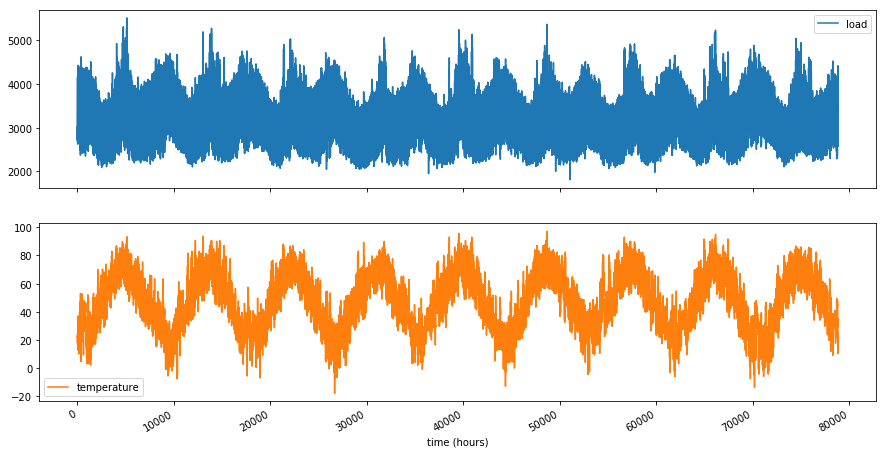

In [83]:
# Let plot the data
df[['load', 'temperature']].plot(subplots=True, figsize=(15, 8))
plt.xlabel('time (hours)')
plt.show()

# Modeling

In [84]:
model = models.WaveNet(filters=64, num_layers=2)

In [85]:
forecaster = Forecaster(
    model,
    lag=lag,  # This is the number of time steps used to predict the future for each data point
    horizon=horizon,  # This is how many time steps into the future we want to produce
    lr=0.001,  # This is the learning rate for the optimizer
    epochs=2
)

In [86]:
forecaster.fit(X_train, y_train, verbose=1)

Epoch 1/2
78601/78601 [==============================] - 82s 1ms/step - loss: -1.4467
Epoch 2/2
78601/78601 [==============================] - 79s 1ms/step - loss: -1.9054


Text(0,0.5,"['Loss']")

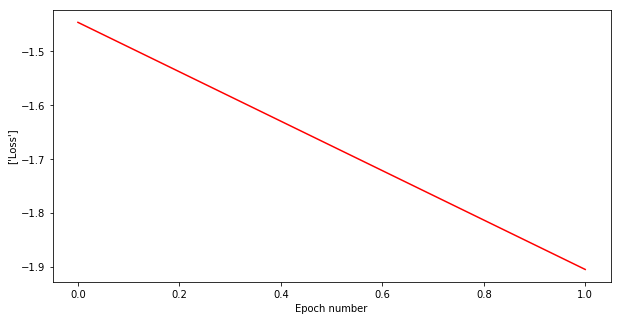

In [87]:
plt.figure(figsize=(10,5))
plt.plot(forecaster.history.epoch, forecaster.history.history['loss'], 'r')
plt.xlabel('Epoch number')
plt.ylabel(['Loss'])

# Evaluation

In [88]:
samples = forecaster.predict(X_test, n_samples=1000)
samples = scaler.inverse_transform_y(samples)
samples = np.expm1(samples)
prediction_mean = np.mean(samples, axis=0)
prediction_lq = np.percentile(samples, q=5, axis=0)
prediction_uq = np.percentile(samples, q=95, axis=0)

SMAPE: 7.17%
Pinball Score: 6585.0
Coverage: 


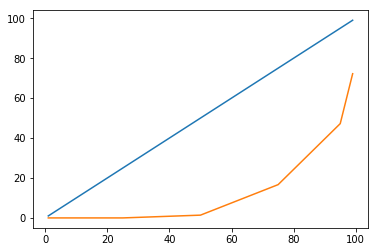

In [89]:
smape = metrics.smape(prediction_mean, y_test)
cov, perc = metrics.coverage(samples, y_test)
pinball = metrics.pinball_loss(samples, y_test)

print('SMAPE: {}%'.format(smape))
print('Pinball Score: {}'.format(pinball))
print('Coverage: ')
plt.plot(perc, perc)
plt.plot(perc, cov)

Lastly, we can check how our predictions compare with the data.

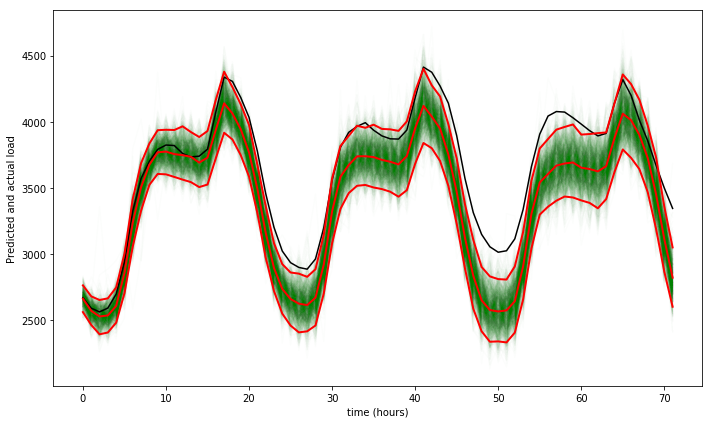

In [90]:
# We're printing the test set data and the predictions for the load data
plt.figure(figsize=(10, 6))
plt.plot(samples[:,0,:,0].T, 'g', alpha=0.01)
plt.plot(y_test[0,:,:], 'k')
plt.plot(prediction_mean[0,:,:], 'r', linewidth=2)
plt.plot(prediction_lq[0,:,:], 'r', linewidth=2)
plt.plot(prediction_uq[0,:,:], 'r', linewidth=2)
plt.xlabel('time (hours)')
plt.ylabel('Predicted and actual load')
plt.tight_layout()